In [1]:
import torch
import json
import gc
import re
import numpy as np
import pickle
from tqdm import tqdm
from pathlib import Path

import matplotlib.pyplot as plt

from s4hci.utils.data_handling import load_adi_data
from s4hci.models.noise import S4Ridge

import torch.nn.functional as F
import torch.multiprocessing as mp

from s4hci.utils.masks import construct_round_rfrr_template, construct_rfrr_mask
from s4hci.utils.adi_tools import combine_residual_stack

from applefy.utils.fake_planets import add_fake_planets
from applefy.utils.file_handling import save_as_fits

## Load the data

In [2]:
print("Loading data ... ", end='')
science_data, raw_angles, raw_psf_template_data = \
    load_adi_data("/fast/mbonse/s4/30_data/EpsEri_0100_C-0656-A.hdf5",
                  data_tag="13_object_final",
                  psf_template_tag="10_psf",
                  para_tag="header_13_object_final/PARANG")

psf_template_data = np.mean(raw_psf_template_data, axis=0)
print("[DONE]")

Loading data ... [DONE]


## Add a fake planet

In [3]:
config_file = "/fast/mbonse/s4/30_data/0100_C-0656-A/configs_cgrid/exp_ID_0363f.json"

In [4]:
with open(config_file) as json_file:
    fake_planet_config = json.load(json_file)

In [5]:
fake_planet_config

{'type': 'TP estimation',
 'flux_ratio': 3.981071705534969e-06,
 'separation': 39.9,
 'planet_position': [72.33357972627272,
  18.096952927174733,
  39.9,
  298.9830508474576],
 'exp_id': '0363f'}

In [6]:
data_with_fake_planet = add_fake_planets(
    input_stack=science_data,
    psf_template=psf_template_data,
    parang=raw_angles,
    dit_psf_template=0.004256,
    dit_science=0.08,
    experiment_config=fake_planet_config,
    scaling_factor=1.0)

In [7]:
X_train = data_with_fake_planet[0::2]
anlges_train = raw_angles[0::2]
X_test = science_data[1::2]
anlges_test = raw_angles[1::2]

In [8]:
del science_data
gc.collect()

0

## Load one S4 Ridge model

In [9]:
models_root_dir = Path("/fast/mbonse/s4/70_results/01_closed_form_hyperparameters/trained_models_norm/")

In [10]:
residual_path = Path("/fast/mbonse/s4/70_results/01_closed_form_hyperparameters/residuals_norm/")

In [11]:
%%time

for tmp_model_file in models_root_dir.iterdir():
    if not tmp_model_file.name.endswith(".pkl"):
        continue
        
    # get the current parameters
    tmp_lambda = float(
        re.search("_lamb_(\d)+.(\d)+_", 
                  tmp_model_file.name).group(0)[6:-1])
    
    tmp_mask = float(
        re.search("_mask_(\d)+.(\d)+", 
                  tmp_model_file.name).group(0)[6:-1])
        
    # restore the model
    s4_ridge = S4Ridge.restore_from_checkpoint(
        available_devices=[0],
        checkpoint_file=tmp_model_file)
    
    # predict
    noise_model, residual = s4_ridge.predict(X_train)
    noise_model_test, residual_test = s4_ridge.predict(X_test)
    
    # build error frame
    mean_error_frame = np.mean(np.abs(residual_test), axis=0)
    median_error_frame = np.median(np.abs(residual_test), axis=0)
    
    # bulid the residuals
    final_residual_mean = combine_residual_stack(
        residual_stack=np.array(residual),
        angles=anlges_train,
        combine=["Mean_Residuals"])
    
    final_residual_median = combine_residual_stack(
        residual_stack=np.array(residual) - np.median(residual, axis=0),
        angles=anlges_train,
        combine=["Median_Residuals"])
    
    # save the result
    planet_name = fake_planet_config["exp_id"]
    dataset_name = planet_name + "_mask_" + str(tmp_mask) + "_lamb_" + str(tmp_lambda) + ".fits"
    
    save_as_fits(final_residual_mean["Mean_Residuals"], 
                 residual_path / Path("mean_residual_" + dataset_name))
    
    save_as_fits(final_residual_median["Median_Residuals"], 
                 residual_path / Path("median_residual_" + dataset_name))
    
    save_as_fits(median_error_frame, 
                 residual_path / Path("median_error_" + dataset_name))
    
    save_as_fits(mean_error_frame, 
                 residual_path / Path("mean_error_" + dataset_name))
    
    break

CPU times: user 1min 5s, sys: 45.1 s, total: 1min 50s
Wall time: 1min 48s


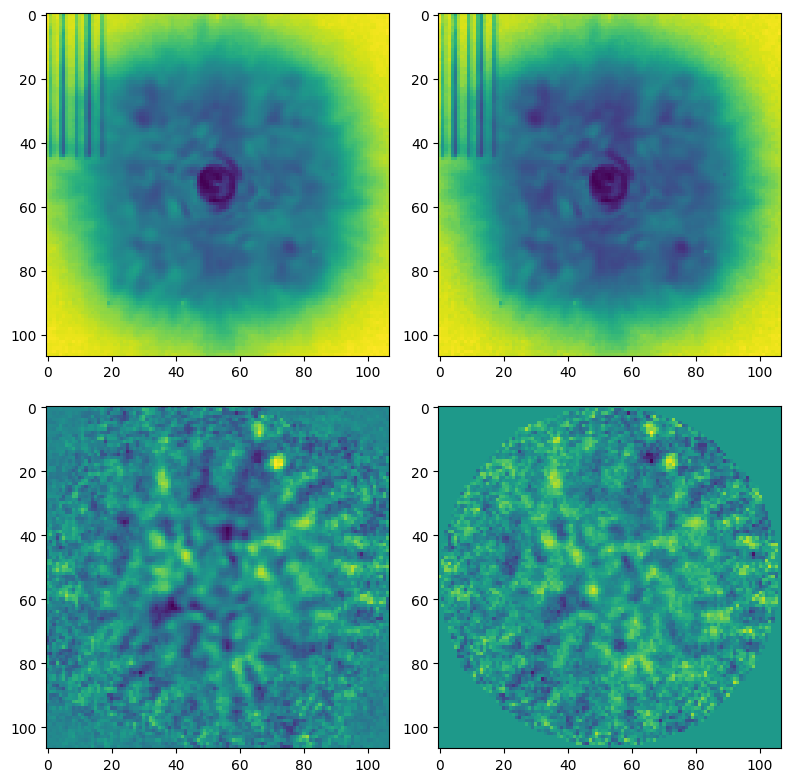

In [12]:
plt.figure(figsize=(8, 8))
ax1 = plt.subplot(2, 2, 1)
ax1.imshow(mean_error_frame)

ax2 = plt.subplot(2, 2, 2)
ax2.imshow(median_error_frame)

ax2 = plt.subplot(2, 2, 3)
ax2.imshow(final_residual_mean["Mean_Residuals"])

ax2 = plt.subplot(2, 2, 4)
ax2.imshow(final_residual_median["Median_Residuals"])

plt.tight_layout()

## Create the txt file for the norm residuals

In [13]:
fake_planet_config_dir = Path("/fast/mbonse/s4/30_data/0100_C-0656-A/configs_cgrid/")

In [14]:
residual_config = "/fast/mbonse/s4/70_results/01_closed_form_hyperparameters/residuals_norm/config.txt"

In [23]:
for tmp_mask in [4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0]:
    for tmp_fake_planet_config in fake_planet_config_dir.iterdir():
        tmp_fake_planet_id = tmp_fake_planet_config.name.split(".json")[0].split("exp_ID_")[1]
        tmp_string = str(tmp_mask) + " " + tmp_fake_planet_id + "\n"
        
        with open(residual_config, 'a') as the_file:
            the_file.write(tmp_string)

In [138]:
model_root_dir = Path("/fast/mbonse/s4/70_results/01_closed_form_hyperparameters/trained_models_norm/")
model_root_dir = Path("/fast/mbonse/s4/70_results/01_closed_form_hyperparameters/trained_models_no_norm/")

In [31]:
for tmp_model in model_root_dir.iterdir():
    print(tmp_model.name)
    print(re.search("_mask_(\d)+.(\d)+",
                    tmp_model.name).group(0)[6:])
    
    print(re.search("_lamb_(\d)+.(\d)+",
                    tmp_model.name).group(0)[6:])

s4_model_lamb_138949.55_mask_7.5.pkl
7.5
138949.55
s4_model_lamb_51794746.79_mask_7.0.pkl
7.0
51794746.79
s4_model_lamb_3727593.72_mask_7.0.pkl
7.0
3727593.72
s4_model_lamb_37.28_mask_5.0.pkl
5.0
37.28
s4_model_lamb_517.95_mask_4.5.pkl
4.5
517.95
s4_model_lamb_100000000.00_mask_5.0.pkl
5.0
100000000.00
s4_model_lamb_71968567.30_mask_7.0.pkl
7.0
71968567.30
s4_model_lamb_5179.47_mask_6.5.pkl
6.5
5179.47
s4_model_lamb_10000000.00_mask_5.0.pkl
5.0
10000000.00
s4_model_lamb_517.95_mask_8.0.pkl
8.0
517.95
s4_model_lamb_268269.58_mask_8.0.pkl
8.0
268269.58
s4_model_lamb_372759.37_mask_5.0.pkl
5.0
372759.37
s4_model_lamb_5179474.68_mask_7.5.pkl
7.5
5179474.68
s4_model_lamb_1389.50_mask_5.0.pkl
5.0
1389.50
s4_model_lamb_1000000.00_mask_6.0.pkl
6.0
1000000.00
s4_model_lamb_5179.47_mask_6.0.pkl
6.0
5179.47
s4_model_lamb_26826.96_mask_6.5.pkl
6.5
26826.96
s4_model_lamb_10000000.00_mask_7.5.pkl
7.5
10000000.00
s4_model_lamb_3727.59_mask_6.5.pkl
6.5
3727.59
s4_model_lamb_10000.00_mask_4.5.pkl
4.5
1

## Merge all residuals

In [2]:
import re
import xarray as xr
from tqdm import tqdm
from applefy.utils.file_handling import open_fits

In [3]:
models_root_dir = Path("/fast/mbonse/s4/70_results/01_closed_form_hyperparameters/residuals_norm/")

In [4]:
#models_root_dir = Path("/fast/mbonse/s4/70_results/01_closed_form_hyperparameters/residuals_no_norm/")

In [5]:
lambda_regs = np.logspace(1, 8, 50)
mask_sizes = [4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0]
fake_planets = ["0000", 
                "0071a", "0117a", 
                "0142b", "0188b", 
                "0190c", "0236c",
                "0240d", "0286d",
                "0267e", "0336e",
                "0317f", "0363f",
                "0343a", "0389a"]

In [30]:
# mean_residual_
# median_residual_
# median_error_
# mean_error_

tmp_name = "mean_error_"

In [31]:
all_residuals = []

missing = 0
found_residuals = 0
missing_file = []

for tmp_fake_planet in  fake_planets:
    tmp_res_planet = []
    
    for tmp_mask in mask_sizes:
        tmp_res_mask = []

        for tmp_lambda_reg in lambda_regs:

            tmp_file_name = tmp_name + tmp_fake_planet + \
                "_mask_" + str(tmp_mask) + \
                "_lamb_{:.2f}".format(tmp_lambda_reg) + ".fits"
            
            file_path = models_root_dir / Path(tmp_file_name)
            
            if not file_path.is_file():
                tmp_file_name = tmp_name + tmp_fake_planet + \
                "_mask_" + str(tmp_mask) + \
                "_lamb_{:.1f}".format(tmp_lambda_reg) + ".fits"
            
                file_path = models_root_dir / Path(tmp_file_name)

            if not file_path.is_file():
                missing+=1
                missing_file.append(file_path)
                tmp_residual = np.zeros((107, 107))
            else:
                found_residuals+=1
                tmp_residual = open_fits(file_path)

            tmp_res_mask.append(tmp_residual)

        tmp_res_planet.append(np.stack(tmp_res_mask))
        
    all_residuals.append(np.stack(tmp_res_planet))
    print(".", end="")

...............

In [32]:
missing_file

[]

In [33]:
missing

0

In [34]:
found_residuals

6000

In [35]:
all_data_norm = xr.DataArray(
    np.array(all_residuals), 
    dims=("fake_planet_id", "mask", "lamb", "x", "y"),
    coords={"fake_planet_id": fake_planets,
            "mask": mask_sizes,
            "lamb": lambda_regs})

In [36]:
result_file = models_root_dir / Path(tmp_name + "combined.nc")
all_data_norm.to_netcdf(result_file)

In [37]:
result_file = models_root_dir / Path(tmp_name + "combined.fits")
save_as_fits(all_data_norm, str(result_file))

OSError: File /fast/mbonse/s4/70_results/01_closed_form_hyperparameters/residuals_norm/mean_error_combined.fits already exists. If you mean to replace it then use the argument "overwrite=True".